In [62]:
import time
import re
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout,       # General
    Embedding, LSTM, Dense, GRU,                              # RNN
    Conv2D, Conv2DTranspose, LeakyReLU, MaxPool2D, Flatten    # CNN
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid

print(tf.__version__)

2.2.0


## **Preprocessing**

In [2]:
# Read the Divina Commedia
url = "https://raw.githubusercontent.com/DanieleVeri/deep_comedy/feature/GANs/divina_commedia.txt"
response = requests.get(url)

divina_commedia = response.text

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")
divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")
divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

# Store unique characters into a dict with numerical encoding
unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run

# Store them in a dict, associated with a numerical index
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }

def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list

encoded_text = numerical_encoding(divina_commedia, char2idx)

def get_text_matrix(sequence, len_input):
    X = np.empty((len(sequence)-len_input, len_input))
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
    return X

text_matrix = get_text_matrix(encoded_text, 100)

# 2D formatted text
canti = divina_commedia.split("\n\n")

num_lines = 0
max_len = 0
for c in canti:
  lines = c.split('\n')
  num_lines += len(lines)
  for l in lines:
    if len(l) > max_len:
      max_len = len(l)

formatted = np.zeros((num_lines, max_len+2), dtype=int)

rhymes = []
num_lines = 0
for i in canti:
  lines = i.split('\n')
  for j in lines:
    rhymes.append(j.split(' ')[-1])
    encoded = numerical_encoding(j+'\n', char2idx)
    left_padding = np.ones(max_len-len(encoded)+2)
    formatted[num_lines, :] = np.concatenate((left_padding, encoded))
    num_lines += 1

print(text_matrix.shape)
print(formatted.shape)


(533803, 100)
(14234, 52)


## **LSTM training**

In [0]:
# size of vocabulary
vocab_size = len(char2idx)
# size of mini batches during training
batch_size = 100
# size of training subset at each epoch
subset_size = batch_size * 100
# vector size of char embeddings
embedding_size = 250
len_input = 1000   # 200
hidden_size = 250  # for Dense() layers

n_epochs = 200
learning_rate = 0.0001

RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    
    LSTM(len_input, return_sequences = True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])
RNN.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, RNN(x), from_logits = True))
    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss

loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    print(epoch)
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))
    
    
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

RNN.save("/text_generator_RNN_00.h5")

## **GANs training**

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 26, 26, 64)        1664      
_________________________________________________________________
leaky_re_lu_300 (LeakyReLU)  (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_115 (Dropout)        (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_301 (LeakyReLU)  (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_116 (Dropout)        (None, 7, 7, 128)      

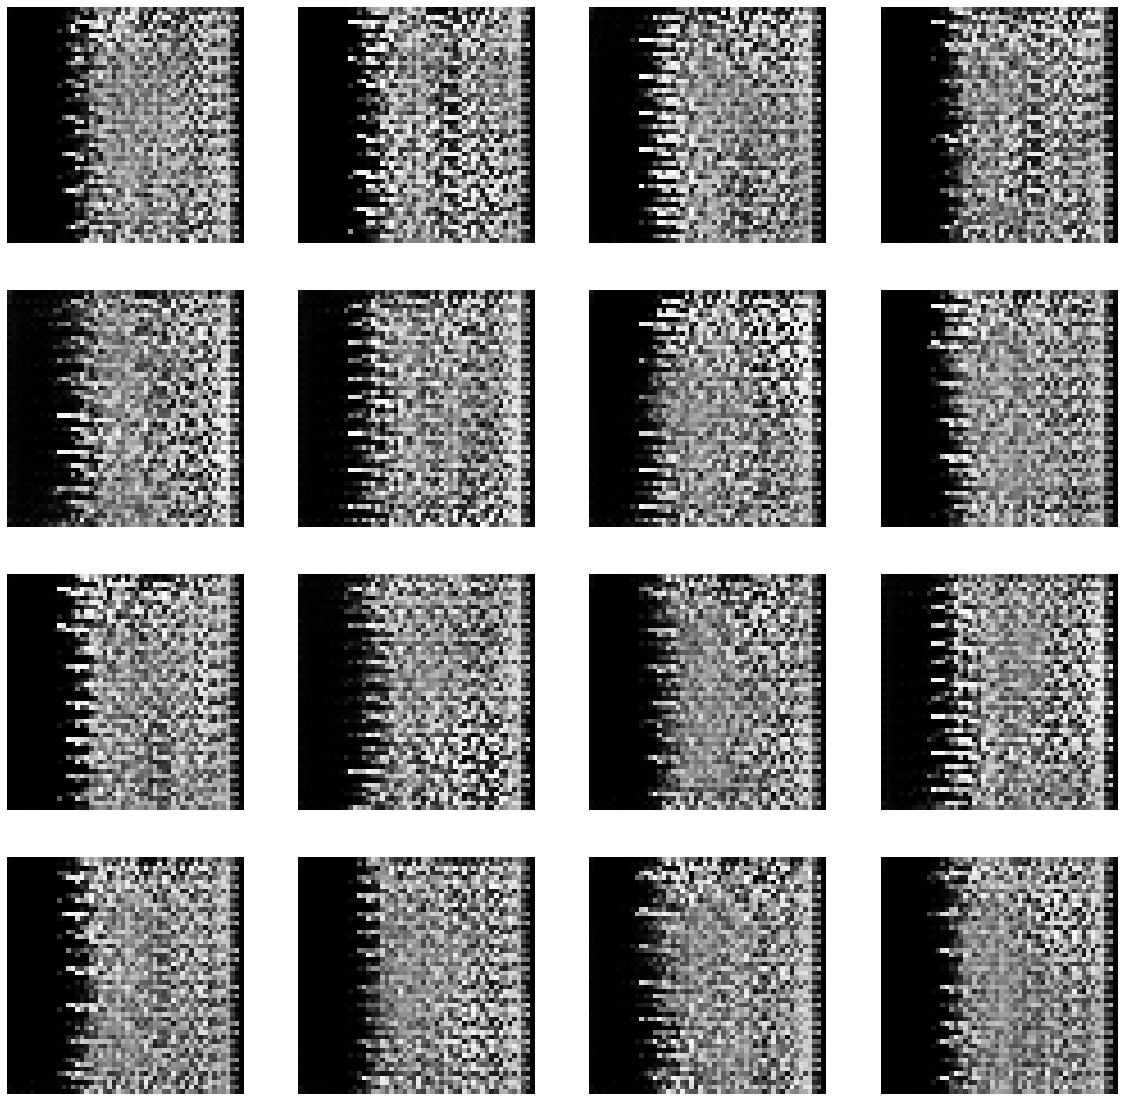

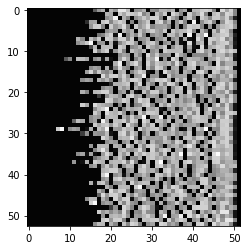

In [65]:
# size of vocabulary
vocab_size = len(char2idx)
normalized = (formatted - vocab_size/2)/(vocab_size / 2)

discriminator = Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[52, 52, 1]))
discriminator.add(LeakyReLU())
discriminator.add(MaxPool2D((2,2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

discriminator.summary()

generator = Sequential()
generator.add(Dense(13*13*256, use_bias=False, input_shape=(100,)))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Reshape((13, 13, 256)))
assert generator.output_shape == (None, 13, 13, 256) # Note: None is the batch size
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator.output_shape == (None, 13, 13, 128)
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 26, 26, 64)
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator.output_shape == (None, 52, 52, 1)

generator.summary()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 256
EPOCHS = 1000

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


idx2char = { v: k for k, v in char2idx.items() } 

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(20,20))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      
      res = []
      for a in range(52):
        line = []
        for b in range(52):
          discretized = math.floor(predictions[i, a, b, 0] * vocab_size/2 + vocab_size/2)
          line.append(idx2char[discretized])
        res.append(''.join(line))
      print("=============")
      print(res)
      print("=============\n\n")
      
  plt.show()

      
splitted = np.split(normalized[0:normalized.shape[0]-normalized.shape[0]%52], normalized.shape[0] // 52)
splitted = np.array(splitted).reshape(len(splitted), 52, 52, 1)
print(splitted.shape)
train_dataset = tf.data.Dataset.from_tensor_slices(splitted).shuffle(60000).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)

plt.imshow(normalized[0:53,:], cmap='gray')
plt.show()



## **LSTM generation:**

In [0]:
generator = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(1, None)),
    
    LSTM(len_input, return_sequences = True, stateful=True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

generator.summary()

# Import trained weights from RNN to generator
generator.set_weights(RNN.get_weights())

def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))

init="""
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.
"""
print(generate_text(init))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 250)            15500     
_________________________________________________________________
gru_2 (GRU)                  (1, None, 1000)           3756000   
_________________________________________________________________
dense_9 (Dense)              (1, None, 250)            250250    
_________________________________________________________________
dense_10 (Dense)             (1, None, 62)             15562     
Total params: 4,037,312
Trainable params: 4,037,312
Non-trainable params: 0
_________________________________________________________________

Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.
  Ahi giustizia tutto mi rispuose;
però è là giù porgoglio soverchia,
ond'era in molin che 'n sè a ver de li avanza.
  Virgilio inverso me